## 1. SOTA-модели и подходы

Описание проекта:  
https://colab.research.google.com/drive/1wGRAB_n26dHi5NRbkx91mlMC7CO8cVYk?usp=sharing#scrollTo=Zc1eyTTDq51T  
  
Face recogtinion pipeline clearly explained (medium):

 https://medium.com/backprop-labs/face-recognition-pipeline-clearly-explained-f57fc0082750

Face landmark detection using PyTorch:

  https://towardsdatascience.com/face-landmarks-detection-with-pytorch-4b4852f5e9c4

Face detection in Python:  
https://machinelearningmastery.com/how-to-perform-face-detection-with-classical-and-deep-learning-methods-in-python-with-keras/

Пример метрики для подсчета качества систем распознавания лиц:

 http://www.eecs.qmul.ac.uk/~sgg/papers/ChengEtAl_PR2020.pdf (секция 3.2.3)

## Примеры кода
- с библиотекой face recognition  
comapare two faces whether those belong to one persone or not  
https://github.com/rjcoder86/Face-Recognition/tree/main  
-  с библиотекой face recognition   
https://realpython.com/face-recognition-with-python/


## 2. Загрузка и обработка данных

Библиотеки для декодирования видео: OpenCV, FFmpeg, GStreamer

In [12]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from PIL import Image
from skimage.io import imread, imshow
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


Загрузим фотографии лиц, которые уже заранее выровнены.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

!unzip -q /content/gdrive/MyDrive/celebA_train_500.zip
!rm -r __MACOSX

Mounted at /content/gdrive/


Содержимое папки с данными:

        - celebA_imgs — папка с выровненными картинками;
        - celebA_anno.txt — файл с аннотацией — каждой картинке из celebA_imgs поставлен в соответствие ее id;
        - celebA_train_split.txt — файл со сплитом на train/val/test

Посмотрим на фотографии лиц

In [13]:
DATA_DIR = './celebA_train_500/celebA_imgs'

files = os.listdir(DATA_DIR)
files_path = [os.path.join(DATA_DIR, file) for file in files]
images = [imread(file) for file in files_path[:4]]

print('Количество всех фото:', len(files))
for i in files[:5]:
    print(i)

Количество всех фото: 23948
000189.jpg
126013.jpg
100595.jpg
015833.jpg
019118.jpg


Размер одного изображения: (218, 178, 3)


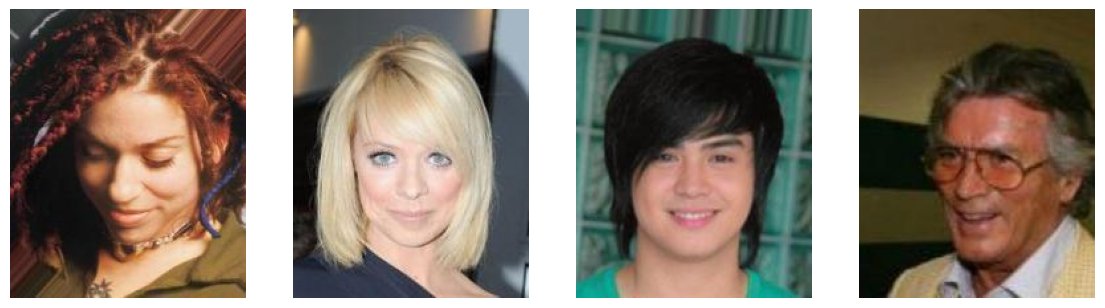

In [14]:
fig, axes = plt.subplots(1, 4, figsize=(14, 4))
for ax, image in zip(axes, images):
    ax.imshow(image)
    ax.axis('off')

print('Размер одного изображения:', images[0].shape)

In [3]:
# DATA_MODES = ['train', 'val', 'test']

In [4]:
RESCALE_SIZE = 224

class FaceDataset(Dataset):
    """
    Датасет с лицами, который паралельно подгружает их из папок
    и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        self.len_ = len(self.files)

    def __len__(self):
        return self.len_

    def load_sample(self, file):  # and prepare join
        image = np.array(Image.open(file))
        return image

    def _prepare_sample(self, image):
        # crope and resize
        image = Image.fromarray(image[77:-41, 45:-50])
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return image

    def __getitem__(self, index):
        if self.mode == 'train':
            # change brightness and flip
            transform = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ColorJitter(brightness=0.3,
                                       contrast=0.3,
                                       saturation=0.3,
                                       hue=0.1),
                transforms.ToTensor(),
                # transforms.Normalize(),
                ])
        else:
            transform = transforms.Compose([
                transforms.ToTensor(),
                # transforms.Normalize(),
                ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = transform(x)

        filename = os.path.basename(self.files[index])
        y = df_anno[df_anno['filename'] == filename]['label']
        y = y.iloc[0]

        return x, y


In [8]:
df_anno = pd.read_csv("celebA_train_500/celebA_anno.txt", header=None, sep=' ')
df_split = pd.read_csv("celebA_train_500/celebA_train_split.txt", header=None, sep=' ')

df_split.columns = ['filename', 'split']
df_anno.columns = ['filename', 'label']

df_anno['filename'].equals(df_split['filename'])

True

In [9]:
# Аннотация к картинке
df_anno.sample(5)

,filename,label
9572,057112.jpg,397
7583,000324.jpg,313
5537,004402.jpg,220
6301,026588.jpg,253
8940,074920.jpg,368


In [11]:
# Принадлежность к выборке
# train (0), test (1), val (2)
df_split.sample(5)

,filename,split
8684,138420.jpg,2
10102,153263.jpg,1
6538,142916.jpg,1
9573,079716.jpg,0
3027,112724.jpg,1


In [6]:
# Списки названий train, test и val файлов
train_files = df_split[df_split['split'] == 0]['filename'].tolist()
test_files = df_split[df_split['split'] == 1]['filename'].tolist()
val_files = df_split[df_split['split'] == 2]['filename'].tolist()

# Списки путей к train, test и val файлам
train_files = [os.path.join(DATA_DIR, file) for file in train_files]
test_files = [os.path.join(DATA_DIR, file) for file in test_files]
val_files = [os.path.join(DATA_DIR, file) for file in val_files]

print(len(train_files))
print(len(test_files))
print(len(val_files))

8544
1878
1589


In [7]:
batch_size = 32

# Dataset
train_dataset = FaceDataset(train_files, mode='train')
test_dataset = FaceDataset(test_files, mode='test')
val_dataset = FaceDataset(val_files, mode='val')

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

## 3. Детекция лица (face detection)

## 4. Выравнивание лица (face alignment)

We can easily apply 2D face alignment inside OpenCV in Python.

## 5. Распознавание лица (face recognition)

In [ ]:
!pip install -q torchvision catalyst
from catalyst import dl, metrics
